In [105]:
# Imports libraries for tiff loading, analysis, and plotting
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.ndimage import label
from skimage.measure import block_reduce
from collections import defaultdict
plt.style.use('Jlab2.mplstyle') #for stylistic edits of graphs etc

In [106]:
#Loads the raw tiff file as a stacked numpy array (frames x width in pixels x height in pixels)
# Could be something that could be easily automated to go through all files in the folder
tif_stack = tiff.imread('/Users/sanjnakartik/Documents/ILESLA/stats/project/ILESLA/Raw Data/20251118_GRAB_ACh_WT_Male/Slice 2 (DLS)/Control/_2/_2_MMStack_Default.ome.tif')


# Loads the mask (a binary image) and convert it to a boolean array
# Essentially a crop, to get FIJI to focus on important bits
mask = tiff.imread('/Users/sanjnakartik/Documents/ILESLA/stats/project/ILESLA/Raw Data/20251118_GRAB_ACh_WT_Male/DLS Mask.tif').astype(bool)

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/skimage/measure/block.py:94: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)), **func_kwargs)


(np.float64(-0.5), np.float64(29.5), np.float64(29.5), np.float64(-0.5))

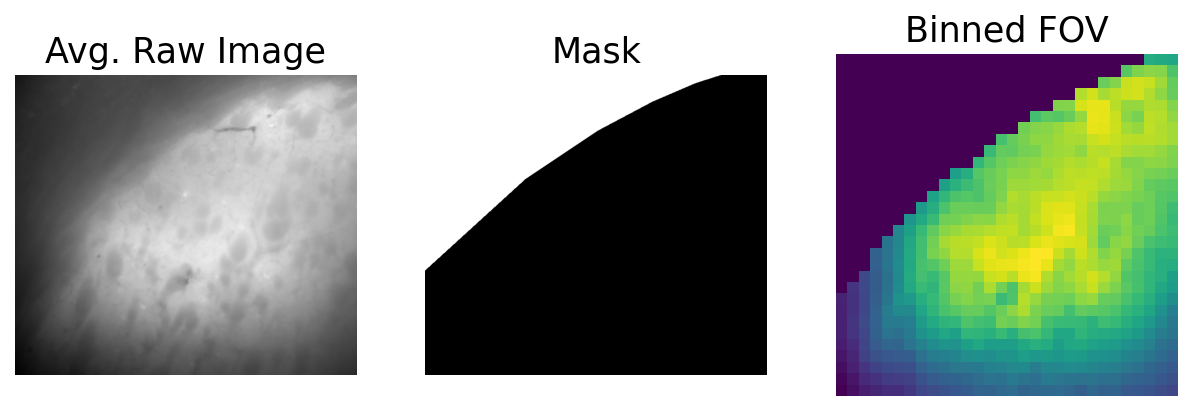

In [107]:
# Sets the number of spatial bins to segment x and y axes
# Could experiment with a different number of bins? 
bin_no = 30

# Applies the mask to set all masked pixels to NaN (non-value)
tif_stack_masked = np.where(mask, np.nan, tif_stack)

#  Defines bins along Y and X
num_bins_y, num_bins_x = bin_no, bin_no

# Computes bin size (pixels per bin in Y & X)
bin_size_y, bin_size_x = tif_stack_masked.shape[1] // num_bins_y, tif_stack_masked.shape[2] // num_bins_x

# Computes cropped height and width
cropped_height, cropped_width = bin_size_y * num_bins_y, bin_size_x * num_bins_x

# Crops the stack to divisible dimensions
cropped_stack = tif_stack_masked[:, :cropped_height, :cropped_width]

# Bins the stack using block averaging (ie averages all pixel values in 1 bin)
binned_stack = block_reduce(
    cropped_stack, 
    block_size=(1, bin_size_y, bin_size_x), 
    func=np.nanmean)

# Identifies masked bins
binned_mask = block_reduce(
    mask[:cropped_height, :cropped_width], 
    block_size=(bin_size_y, bin_size_x), 
    func=np.nanmax)

# Sets masked bins to NaN
binned_stack[:, binned_mask == 1] = np.nan

# Computes the minimum nonNaN bin value
# Sets the background 0 value
min_bin_value = np.nanmin(np.mean(binned_stack, axis=0))

# Replaces NaN values with the minimum value
# IE pretends that NaN values = lowest min background noise
binned_stack = np.nan_to_num(binned_stack, nan=min_bin_value)

fig, ax = plt.subplots(1,3, figsize=(10, 10))
# Plots the average projection of the raw tiff file across the full recording
ax[0].imshow(np.mean(tif_stack, axis=0), cmap='gray')
ax[0].set(title='Avg. Raw Image')
ax[0].axis('off')

# Plots the mask to show the area(s) excluded from subsequent analyses
ax[1].imshow(mask, cmap='gray')
ax[1].set(title='Mask')
ax[1].axis('off')

# Plots mean activity across the binned FOV (Field of View)
img = ax[2].imshow(np.mean(binned_stack, axis=0), cmap='viridis', aspect='auto')
ax[2].set_title('Binned FOV')
ax[2].set(xlabel='Bin', ylabel='Bin')
ax[2].set_aspect('equal')
ax[2].axis('off')

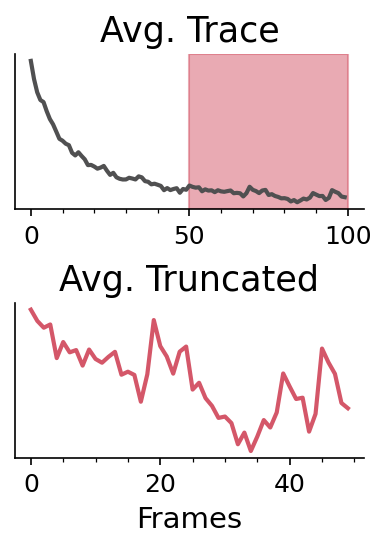

In [108]:
# Excludes the first n frames of data (i.e. exponential decay artefact) 
excluded_frames = 50
trunc_stack = binned_stack[excluded_frames:]

fig, ax = plt.subplots(2,1, figsize=(3,3.5))
ax[0].plot(binned_stack.mean(axis=(1,2)), linewidth=2)
ax[0].axvspan(excluded_frames, len(tif_stack), color='C1', alpha=0.5)
ax[0].get_yaxis().set_visible(False)
ax[0].set(title='Avg. Trace')

ax[1].plot(trunc_stack.mean(axis=(1,2)), color='C1', linewidth=2)
ax[1].get_yaxis().set_visible(False)
ax[1].set(title='Avg. Truncated', xlabel='Frames')

plt.subplots_adjust(hspace=0.6)

In [109]:
def sliding_dff(trunc_stack, window_size=100, percentile=8):
    """
    Calculate ΔF/F using a sliding window with a specified percentile.

    Parameters:
        trunc_stack (np.ndarray): 3D array of fluorescence data (frames, height, width).
        window_size (int): Number of frames in the sliding window (ensure longer than events).
        percentile (float): Percentile to calculate F₀ in each window.
    
    Returns:
        dff_stack (np.ndarray): ΔF/F normalized fluorescence data for each bin.
    """
    # Initialises F0 array
    F0_sliding = np.empty_like(trunc_stack)

    # Iterates over frames
    for frame in range(trunc_stack.shape[0]):
        # Defines the start and end of the window
        start_frame = max(0, frame - window_size)
        end_frame = min(trunc_stack.shape[0], frame + window_size)

        # Calculates the percentile for F0 (ignoring NaNs)
        F0_sliding[frame] = np.nanpercentile(
            trunc_stack[max(0, frame - window_size):max(1, frame)], percentile, axis=0
        )

    # Calculates ΔF/F
    dff_stack = (trunc_stack - F0_sliding) / F0_sliding
    
    return dff_stack

dff_stack = sliding_dff(trunc_stack)

# Gets the dimensions of the dff stack (frames, height, width)
_, binned_height, binned_width = dff_stack.shape

# Generates a list of all bin coordinates
bins = [(y, x) for y in range(binned_height) for x in range(binned_width)]

In [110]:
def detect_events(dff_stack, bins, filter_window=5, prominence=5, min_event_length=5, 
                  filter_polyorder=2, threshold=5, min_distance=2, frame_rate=10, percentile=90):

    aligned_events = []    # Creates a list to store merged (aligned) events
    all_event_frames = []  # Creates a list to store the frames of detected events

    for bin_coords in bins: # Scans through each bin in frame
        y, x = bin_coords
        trace = dff_stack[:, y, x]  # Extracts ΔF/F trace for this specific bin
        
        # Smooths the trace using a Savitzky-Golay filter
        smoothed_trace = savgol_filter(trace, window_length=int(filter_window), polyorder=filter_polyorder)
        
        # Computes percentile threshold and noise estimate (sigma via MAD)
        # Defines at which point a signal is classed as an event??
        percentile_threshold = np.nanpercentile(smoothed_trace, percentile)
        mad = np.nanmedian(np.abs(smoothed_trace - np.nanmedian(smoothed_trace))) + 1e-12
        sigma = 1.4826 * mad # A statistical trick to make MAD an unbiased estimator of stdev
        
        #Checks for understanding Sigma and MAD:
        #print("Sigma is:", sigma)
        #print("MAD is:", mad)
        
        # Detects peaks above threshold with required prominence and spacing
        peaks, _ = find_peaks(smoothed_trace, 
                              height=threshold * sigma,
                              prominence=prominence * sigma,
                              distance=min_distance)

        # Identifies event start/end around each peak
        for peak in peaks:
            start = peak                            # Search backward to event onset
            while start > 0 and smoothed_trace[start - 1] > percentile_threshold:
                start -= 1
            end = peak                              # Search forward to even offset
            while end < len(smoothed_trace) - 1 and smoothed_trace[end + 1] > percentile_threshold:
                end += 1
            if (end - start) >= min_event_length:   # Store only sufficiently long events
                all_event_frames.append((peak, start, end, bin_coords))

    # Sort all detected events by peak frame
    all_event_frames.sort(key=lambda x: x[0])  
    #return all_event_frames

    aligned_events = []  # Creates a list to store merged (aligned) events
    
    for peak_frame, start, end, bin_coords in all_event_frames:
        # Stores the details of the first event
        if not aligned_events:
            aligned_events.append({
                'start': int(start),
                'end': int(end),
                'bins': [bin_coords],
                'peak': int(peak_frame)  
            })
            continue

        last = aligned_events[-1]   # Most recent grouped event
        frame_range = 10            # Merge events whose peaks occur within ±10 frames
        if abs(peak_frame - last['peak']) <= frame_range:
            last['start'] = int(min(last['start'], start))   # Extend event start if needed
            last['end']   = int(max(last['end'], end))       # Extend event end if needed
            last['bins'].append(bin_coords)                  # Add contributing bin
        else:
            # Stores a new event
            aligned_events.append({
                'start': int(start),
                'end': int(end),
                'bins': [bin_coords],
                'peak': int(peak_frame)
            })
    # print(aligned_events)
    # print(len(aligned_events))
    return aligned_events


In [111]:
all_event_frames = detect_events(dff_stack, bins, filter_window=5, min_event_length=1,                    
                               prominence=6, threshold=5, min_distance=1, percentile=50) 
#here, all_event_frames is being used to store the output of the original code, i.e. events detected, sorted by peak and then merged within 10 frames
print("detected events and merged. yay!")
print(all_event_frames)

detected events and merged. yay!
[{'start': 18, 'end': 28, 'bins': [(11, 21), (14, 19), (15, 22), (19, 21), (20, 22), (21, 21), (21, 22), (21, 23)], 'peak': 19}, {'start': 36, 'end': 49, 'bins': [(14, 10), (11, 12), (12, 11), (12, 12), (12, 13), (13, 8), (13, 9), (13, 10), (13, 11), (15, 8), (15, 9), (15, 10), (15, 11), (16, 7), (16, 9), (16, 10), (16, 11), (17, 11), (17, 12), (17, 13), (17, 14), (18, 10), (18, 11), (18, 12), (19, 13), (29, 10)], 'peak': 45}]


In [112]:
###################### LAILA V2 #######################

# Input:
#   aligned_events = list of { 'start':..., 'end':..., 'bins': [(y,x), ...], 'peak':... }
# Output:
#   distinct_event_coords = { "event 1": [(y,x),...], "event 2": [...] }


# 1. PREPARE UNIQUE COORDINATE LISTS FOR LOOKUP
all_coords = []                              # Makes a list of all bins containing fluorescence
for peak_frame, start, end, bin_coords in all_event_frames:       # Adds all the event coordinates from the above bit to one easy to search list
    all_coords.append(bin_coords)      
coords_set = set(all_coords)                 # Makes the list a set for easier searching
coords_list = sorted(coords_set)             # For deterministic processing order, optional but helpful for understanding

# 2. SETUP DATA STRUCTURES
distinct_event_coords = {}                   # Maps event name to list of (y,x) bin locations
coord_to_event = {}                          # Maps (y,x) to the event name for adding extra bins to events in distinct_event_coords
next_event_id = 1
print("Finished making data structures ok")

##MOVE TO NEXT CELL FROM HERE TO RUN SANJNA'S CODE

# # helper: parse numeric suffix from "event N" for deterministic merging choice
# def event_id_num(evname):
#     try:
#         return int(evname.split()[-1])
#     except Exception:
#         return float('inf')

# # 3. NEIGHBOUR OFFSETS FOR QUEEN ADJACENCY.... using Sanjna's updates
# from itertools import product
# neighbour_offsets = [(dy, dx) for dy, dx in product((-1,0,1), repeat=2) if (dy,dx) != (0,0)] 

Finished making data structures ok


In [113]:
##Need this class of UnionFind to UnionMerge groups of events as they grow - this is the more robust
#Run this before running the merge

class UnionFind:
    def __init__(self):
        self.parent = {}
        self.rank = {}

    def make(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0

    def find(self, x):
        # path compression
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, a, b):
        # union by rank
        ra = self.find(a)
        rb = self.find(b)
        if ra == rb:
            return ra
        if self.rank[ra] < self.rank[rb]:
            ra, rb = rb, ra
        self.parent[rb] = ra
        if self.rank[ra] == self.rank[rb]:
            self.rank[ra] += 1
        return ra
    print("UnionFind successfully run")

UnionFind successfully run


In [114]:
##Spatially separate the events now:
def spatial_segment(all_event_frames):

    from collections import defaultdict

    uf = UnionFind() #calls the class we defined above
    distinct_events = {}
    coord_to_group = {}
    counter = 1
    next_group_ID = 1

    for event in all_event_frames:
        event_bins = event['bins']
        for ev_bin in event_bins:
        #if event not in distinct_events: #we may want to remove this if statement and just loop already depending on how this runs
            bin_y = ev_bin[0]
            bin_x = ev_bin[1]
            bin_coords = ev_bin
            print(bin_coords) #just printing as a sanity check
            coord = (bin_y,bin_x)
            print(coord) #print this also a sanity check - should match bin_coords above

            #will need to modify/delete this in the final code where we add in the time component:
            if coord in coord_to_group:
                continue
            
            #building the catchment range - currently we have hard-coded a range of 8 Queen neighbours
            catchment_range = [
                (bin_y, bin_x+1), (bin_y, bin_x-1), 
                (bin_y+1, bin_x+1), (bin_y+1, bin_x), 
                (bin_y-1, bin_x) , (bin_y-1, bin_x-1), 
                (bin_y-1, bin_x+1), (bin_y+1, bin_x-1)]

            # find groups present in neighbours (may be zero, one, or multiple)
            neighbour_group_ids = {coord_to_group[n] for n in catchment_range if n in coord_to_group}
            
            #if any([b in distinct_events for b in catchment_range]):
            if not neighbour_group_ids:
                # no neighbour -> create new provisional group
                gid = next_group_ID
                next_group_ID += 1  
                uf.make(gid)
                coord_to_group[coord] = gid
                
            else:
                # pick one gid as anchor (first in set) and attach coord to it
                # then union all neighbour gids together so they become one set
                # Note: converting set to list gives deterministic order in Python >=3.7,
                # but we don't rely on order because union-find canonicalizes later.
                gids = list(neighbour_group_ids)
                anchor = gids[0]
                coord_to_group[coord] = anchor
                uf.make(anchor)  # in case it wasn't created (should be)
                for other in gids[1:]:
                    uf.make(other)
                    uf.union(anchor, other)
                # (anchor vs other order doesn't matter; uf keeps sets)
    print("First pass done")

    # Second pass: canonicalize provisional gids -> root ids, relabel to contiguous 1..N
    # Build mapping provisional_gid -> root
    provgid_to_root = {}
    for gid in list(uf.parent.keys()):
        provgid_to_root[gid] = uf.find(gid)

    # Map each root to a new compact id (1..M)
    root_to_newid = {}
    new_next = 1
    for root in sorted(set(provgid_to_root.values())):
        root_to_newid[root] = new_next
        new_next += 1

    # Build final coord -> group_id mapping
    coord_to_new_group = {}
    for coord, prov_gid in coord_to_group.items():
        root = provgid_to_root[prov_gid]
        final_gid = root_to_newid[root]
        coord_to_new_group[coord] = final_gid

    # Build groups dict (final_gid -> list coords)
    groups = defaultdict(list)
    for coord, gid in coord_to_new_group.items():
        groups[gid].append(coord)

    groups = {gid: sorted(coords) for gid, coords in groups.items()}

    print("Group dictionary built")

    # Build member_assignments aligned with all_event_frames
    member_assignments = []
    for ev in all_event_frames:
        try:
            _, _, event_bins, _,
        except Exception:
        #     bin_coords = None
            print("invalid input structure")
        
        for eb in event_bins:
            bin_coords = eb
            if bin_coords is None:
                member_assignments.append(None)
                continue
    
            coord = (int(bin_coords[0]), int(bin_coords[1]))
            member_assignments.append(coord_to_new_group.get(coord, None))

    return groups, member_assignments, coord_to_new_group
    print (coord_to_new_group)
    #print ("distinct events", distinct_events)

In [115]:
groups, member_assignments, coord_to_group = spatial_segment(all_event_frames)


(11, 21)
(11, 21)
(14, 19)
(14, 19)
(15, 22)
(15, 22)
(19, 21)
(19, 21)
(20, 22)
(20, 22)
(21, 21)
(21, 21)
(21, 22)
(21, 22)
(21, 23)
(21, 23)
(14, 10)
(14, 10)
(11, 12)
(11, 12)
(12, 11)
(12, 11)
(12, 12)
(12, 12)
(12, 13)
(12, 13)
(13, 8)
(13, 8)
(13, 9)
(13, 9)
(13, 10)
(13, 10)
(13, 11)
(13, 11)
(15, 8)
(15, 8)
(15, 9)
(15, 9)
(15, 10)
(15, 10)
(15, 11)
(15, 11)
(16, 7)
(16, 7)
(16, 9)
(16, 9)
(16, 10)
(16, 10)
(16, 11)
(16, 11)
(17, 11)
(17, 11)
(17, 12)
(17, 12)
(17, 13)
(17, 13)
(17, 14)
(17, 14)
(18, 10)
(18, 10)
(18, 11)
(18, 11)
(18, 12)
(18, 12)
(19, 13)
(19, 13)
(29, 10)
(29, 10)
First pass done
Group dictionary built


In [116]:
# #OLD BRIDGING CODE - DO NOT RUN

# #Need to convert the output of the spatial separation function to also include time information - so this is a bridging bit of code that does that
# group_events = {}

# for (peak, start, end, (y,x), gid) in zip(all_event_frames, member_assignments):
#     if gid is None:
#         continue
#     group_events.setdefault(gid, []).append(
#         {
#             "peak": int(peak),
#             "start": int(start),
#             "end": int(end),
#             "coord": (int(y), int(x))
#         }
#     )
# group_summaries = {}

# for gid, events in group_events.items():
#     group_start = min(e["start"] for e in events)
#     group_end   = max(e["end"]   for e in events)
#     group_peak  = max(e["peak"]  for e in events)

#     group_summaries[gid] = {
#         "start": group_start,
#         "end": group_end,
#         "peak": group_peak,
#         "bins": [e["coord"] for e in events],
#         "n_bins": len(events)
#     }

In [117]:
import pandas as pd
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Any

def aggregate_aligned_events_to_groups(
    aligned_events: List[Dict[str, Any]],
    coord_to_group: Dict[Tuple[int,int], int],
    *,
    missing_policy: str = "skip",
    peak_aggregation: str = "max"
):
    """
    Build group-level time summaries from aligned_events + coord->group mapping.

    Parameters
    ----------
    aligned_events : list of dict
        Each dict must contain keys 'start', 'end', 'bins' (list of (y,x)), and 'peak'.
    coord_to_group : dict
        Mapping (y,x) -> group_id produced by spatial segmentation.
    missing_policy : {'skip','none','new'}
        - 'skip' : ignore bins not in coord_to_group (default)
        - 'none' : assign group_id = None for unmatched bins
        - 'new'  : create new group ids for unmatched coords (appends after existing max id)
    peak_aggregation : {'max','mode','median'}
        How to pick the group's representative peak.
          - 'max'    -> max of per-bin peaks
          - 'mode'   -> most frequent peak value (break ties by max)
          - 'median' -> median of peaks (rounded to int)
    Returns
    -------
    group_summaries : dict
        {group_id: {'start':int,'end':int,'peak':int,'bins':[(y,x),...],'n_bins':int}}
    df_groups : pd.DataFrame
        DataFrame with columns ['group_id','start','end','peak','n_bins','bins'] (bins is a list)
    aligned_event_to_groups : list
        For each aligned_event (same order), the set/list of group_ids touched by that aligned_event.
    """
    # defensive checks
    if peak_aggregation not in {"max","mode","median"}:
        raise ValueError("peak_aggregation must be one of 'max','mode','median'")

    # If we might create new groups for missing coords, find starting gid
    max_existing_gid = max(coord_to_group.values()) if coord_to_group else 0
    next_new_gid = max_existing_gid + 1

    # Collect per-group events
    group_event_rows = defaultdict(list)
    aligned_event_to_groups = []  # for each aligned_event, which groups it touches (set)

    for evt_idx, evt in enumerate(aligned_events):
        start = int(evt.get("start"))
        end   = int(evt.get("end"))
        peak  = int(evt.get("peak"))
        bins  = evt.get("bins", [])

        touched_groups = set()
        for coord in bins:
            coord = (int(coord[0]), int(coord[1]))  # ensure tuple of ints
            if coord in coord_to_group:
                gid = coord_to_group[coord]
            else:
                if missing_policy == "skip":
                    continue
                elif missing_policy == "none":
                    gid = None
                elif missing_policy == "new":
                    gid = next_new_gid
                    coord_to_group[coord] = gid
                    next_new_gid += 1
                else:
                    raise ValueError("unknown missing_policy: "+str(missing_policy))

            # record one bin-level event (time info comes from the aligned_event)
            group_event_rows[gid].append({"start": start, "end": end, "peak": peak, "coord": coord})
            touched_groups.add(gid)

        # store the set (or empty set) for this aligned_event
        aligned_event_to_groups.append(sorted(touched_groups))

    # Now build group summaries
    group_summaries = {}
    for gid, rows in group_event_rows.items():
        if not rows:
            continue
        starts = [r["start"] for r in rows]
        ends   = [r["end"]   for r in rows]
        peaks  = [r["peak"]  for r in rows]
        bins   = [r["coord"] for r in rows]

        # aggregate peak
        if peak_aggregation == "max":
            group_peak = int(max(peaks))
        elif peak_aggregation == "median":
            import numpy as _np
            group_peak = int(_np.median(peaks))
        elif peak_aggregation == "mode":
            # mode: most common peak value; break ties by picking the largest
            c = Counter(peaks)
            most_common_count = max(c.values())
            candidates = [val for val,count in c.items() if count == most_common_count]
            group_peak = int(max(candidates))

        group_start = int(min(starts))
        group_end   = int(max(ends))

        group_summaries[gid] = {
            "start": group_start,
            "end": group_end,
            "peak": group_peak,
            "bins": sorted(set(bins)),
            "n_bins": len(set(bins))
        }

    # Convert to DataFrame
    df_rows = []
    for gid, info in sorted(group_summaries.items(), key=lambda kv: (kv[0] is None, kv[0])):  # put None at front if present
        df_rows.append({
            "group_id": gid,
            "start": info["start"],
            "end": info["end"],
            "peak": info["peak"],
            "n_bins": info["n_bins"],
            "bins": info["bins"]
        })

    df_groups = pd.DataFrame(df_rows, columns=["group_id","start","end","peak","n_bins","bins"])

    return group_summaries, df_groups, aligned_event_to_groups


In [118]:
# suppose you already ran spatial segmentation adapted for aligned_events:
# groups, member_assignments, coord_to_group = your_spatial_segmentation(aligned_events)

group_summaries, df_groups, aligned_event_to_groups = aggregate_aligned_events_to_groups(
    all_event_frames,
    coord_to_group,
    missing_policy="skip",      # or 'new' if you want unmatched coords to become new groups
    peak_aggregation="max"      # or 'mode' / 'median'
)

print(df_groups.head())
# Inspect group_summaries for programmatic use


   group_id  start  end  peak  n_bins  \
0         1     18   28    19       1   
1         2     18   28    19       1   
2         3     18   28    19       1   
3         4     18   28    19       5   
4         5     36   49    45      25   

                                                bins  
0                                         [(11, 21)]  
1                                         [(14, 19)]  
2                                         [(15, 22)]  
3  [(19, 21), (20, 22), (21, 21), (21, 22), (21, ...  
4  [(11, 12), (12, 11), (12, 12), (12, 13), (13, ...  


In [119]:
def get_max_bins(aligned_events, filter_window=5, min_event_length=1, 
                 prominence=6, threshold=5, min_distance=1, percentile=50, 
                 filter_polyorder=2):
    # ===== plotting (uses event['peak'] to draw a vertical line) =====
    #interestingly, this has a much lower percentile threshold - but the percentile is of aligned events
    max_bin_events = []
    
    for event in aligned_events:
        event_start = event['start']
        event_end = event['end']
    
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
        avg_image = np.nanmax(dff_stack[event_start:event_end+1], axis=0)
        min_bin_value = np.nanmin(avg_image)
        avg_image = np.nan_to_num(avg_image, nan=min_bin_value)
        avg_image[avg_image == min_bin_value] = np.nanmin(avg_image[avg_image > min_bin_value])
        img = ax[1].imshow(avg_image, cmap='viridis', aspect='auto', vmin=(np.nanmin(avg_image)) * 9, vmax=np.nanmax(avg_image))
        plt.colorbar(img, ax=ax[1], label='ΔF/F₀')
        max_heatmap_coords = np.unravel_index(np.nanargmax(avg_image), avg_image.shape)
        ax[1].scatter(max_heatmap_coords[1], max_heatmap_coords[0], color='indianred', label="Selected Bin")
        ax[1].set_title(f"Event Max Intensity (Frames {event_start}:{event_end})")
        ax[1].set_xlabel("Binned X")
        ax[1].set_ylabel("Binned Y")
    
    
        y, x = max_heatmap_coords
        trace = dff_stack[:, y, x]
        smoothed_max_trace = savgol_filter(trace, window_length=int(filter_window), polyorder=filter_polyorder)
        percentile_threshold = np.nanpercentile(smoothed_max_trace, percentile)
        mad = np.nanmedian(np.abs(smoothed_max_trace - np.nanmedian(smoothed_max_trace))) + 1e-12
        sigma = 1.4826 * mad
    
        # detect and store fram at which peaks occur, in an array called 'peaks'
        peaks, props = find_peaks(smoothed_max_trace, 
                              height=threshold * sigma,
                              prominence=prominence * sigma,
                              distance=min_distance)
    
        # for every detected peak, find where the signal starts and ends
        for peak in peaks:
            # starting at the peak, move backwards in frames until the signal drops below a chosen baseline
            max_start = peak
            while max_start > 0 and smoothed_max_trace[max_start - 1] > percentile_threshold:
                max_start -= 1
            # starting at the peak, move foreards in frames until the signal drops below a chosen baseline
            max_end = peak
            while max_end < len(smoothed_max_trace) - 1 and smoothed_max_trace[max_end + 1] > percentile_threshold:
                max_end += 1
            max_start = max_start - 1   ### Hard coded since optimal detection was off by 1 frame
            max_end = max_end + 1   ### Hard coded since optimal detection was off by 1 frame
    
        max_bin_events.append({
            "event_start": max_start,
            "event_end": max_end,
            "bin": (y, x),
            "peak frame": max_start + np.argmax(smoothed_max_trace[max_start:max_end])
        })
    
    
    # max_event_frames
    
        ax[0].plot(smoothed_max_trace, color='C2', linewidth=4, label='Smoothed ΔF/F₀', zorder=1)
        ax[0].axvline((max_start + np.argmax(smoothed_max_trace[max_start:max_end])), color='C2', linewidth=2, linestyle='--')
        ax[0].axvspan(max_start, max_end, color='C2', alpha=0.4)
        ax[0].axhline(threshold * sigma, color='gray', linestyle='--', label='Threshold', zorder=2)
        ax[0].axhline(percentile_threshold, color='green', linestyle='--', label=f'{percentile}th Percentile', zorder=2)
    

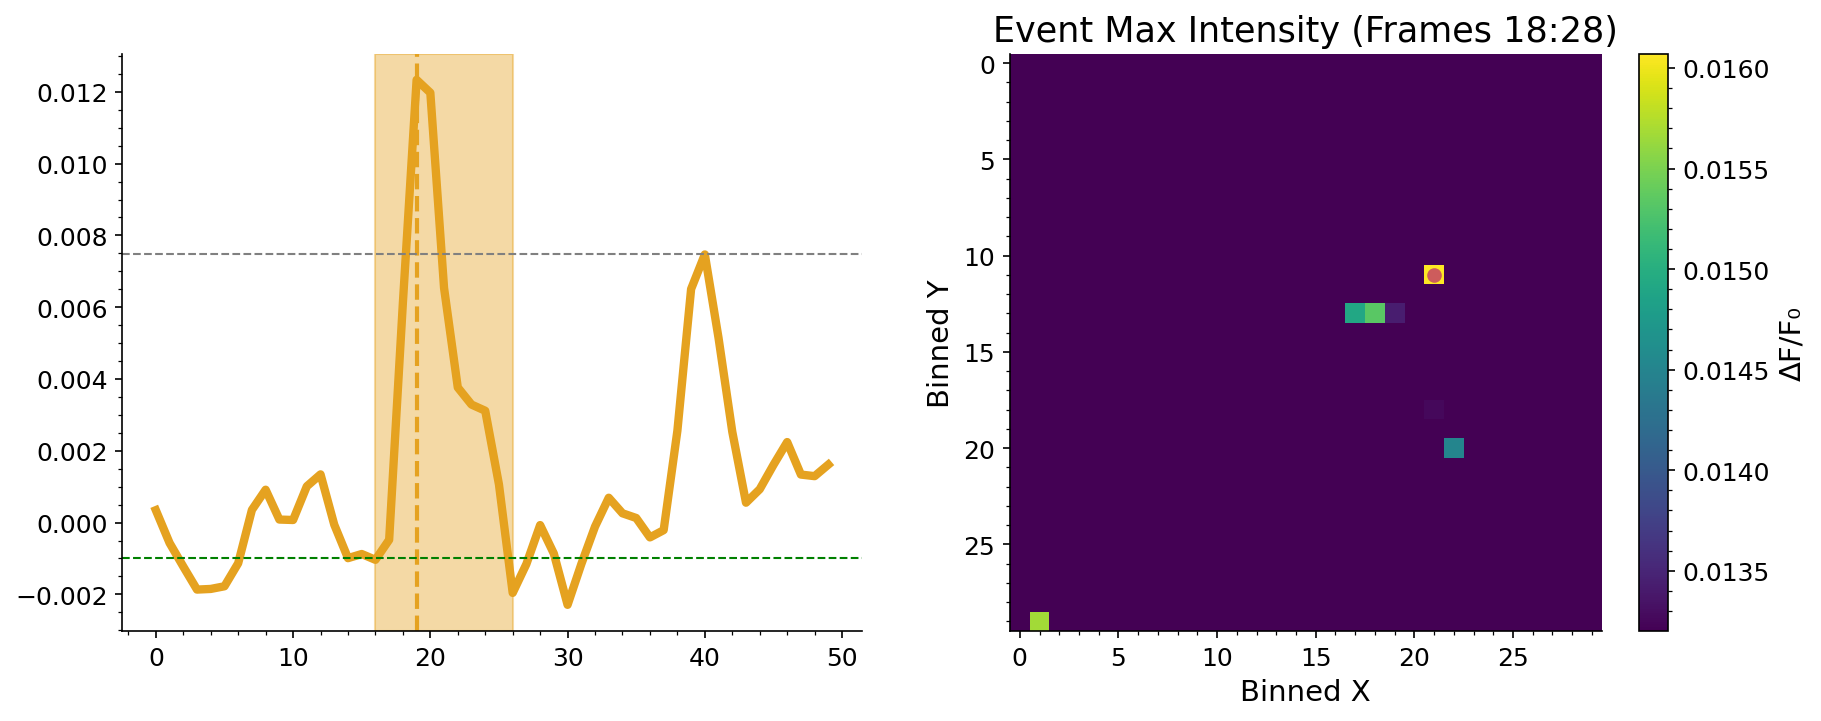

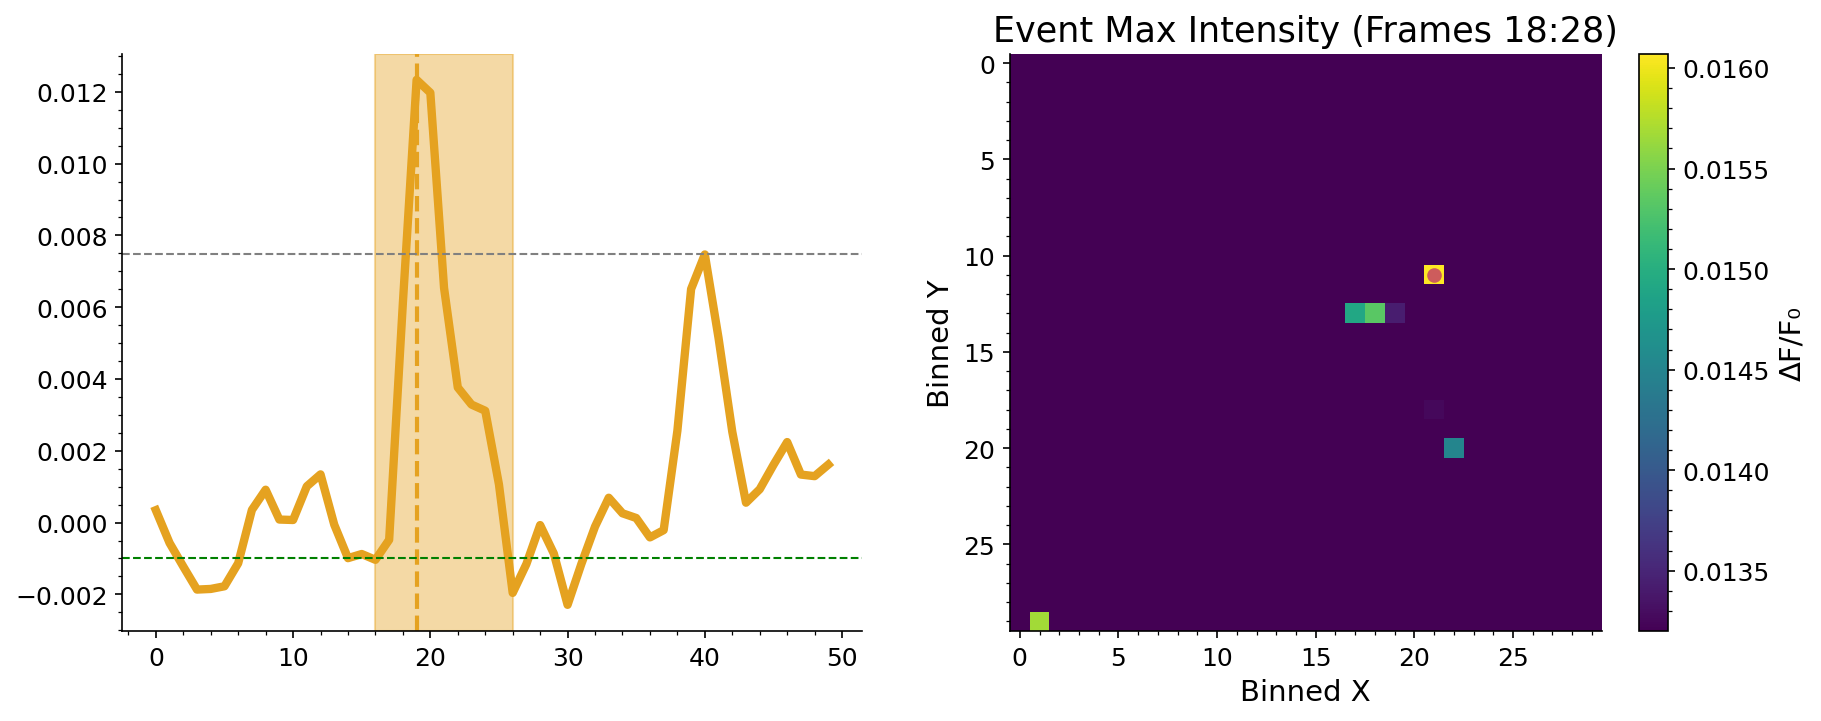

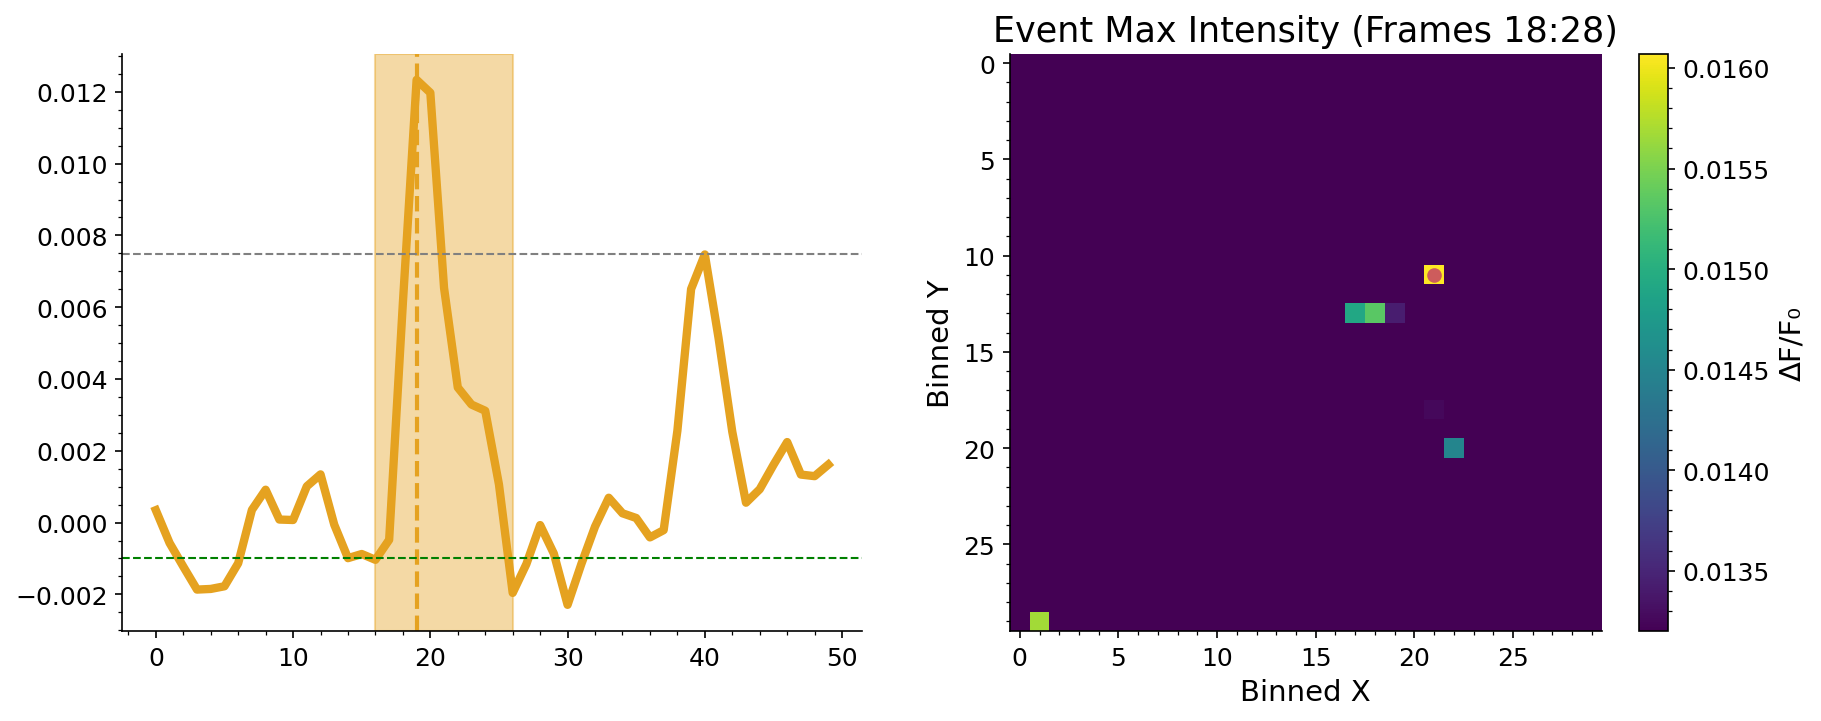

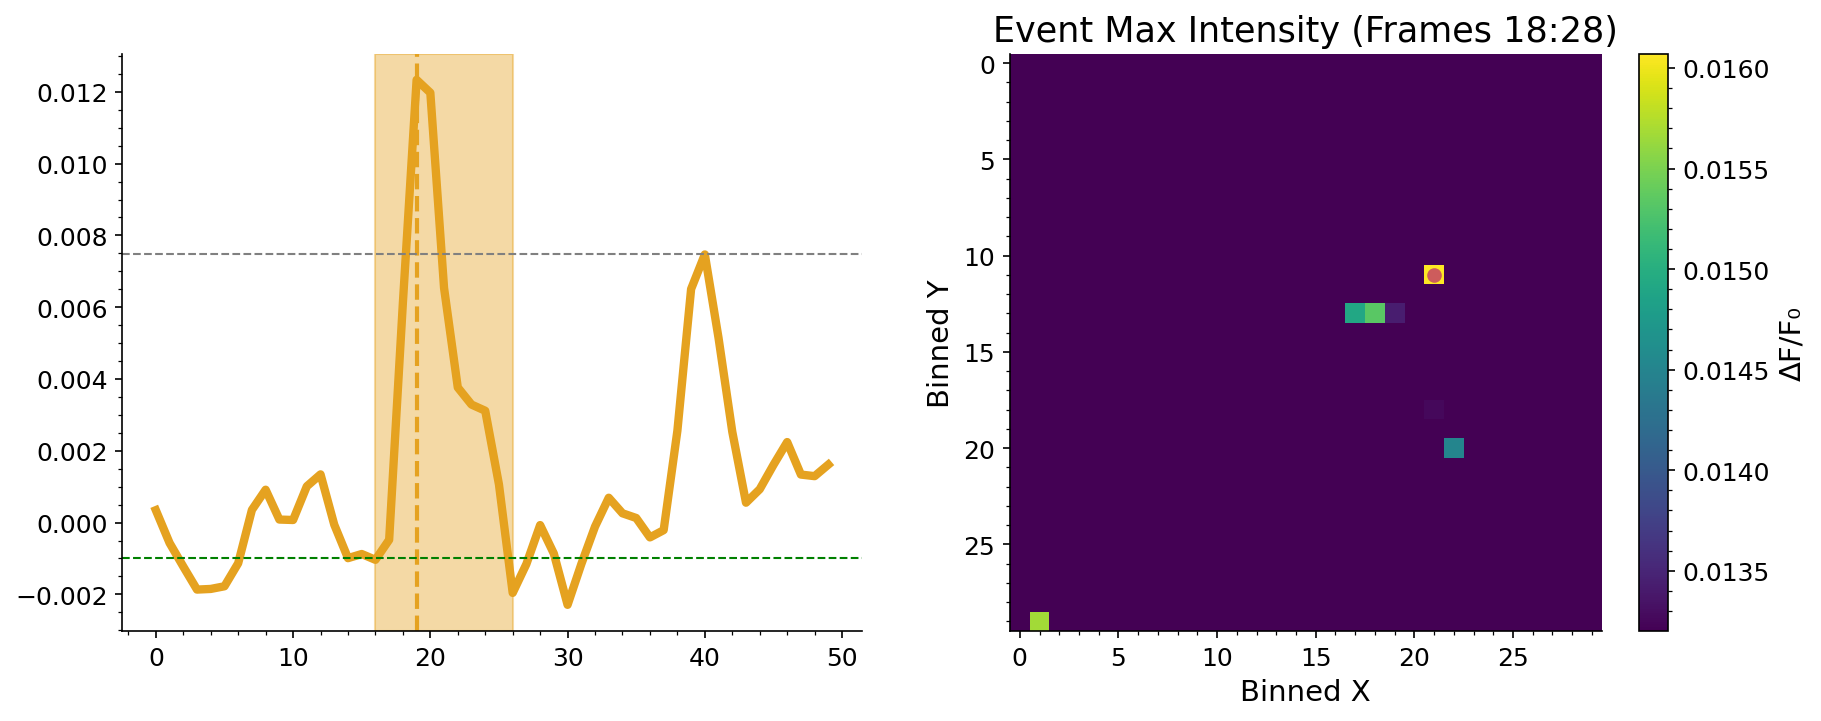

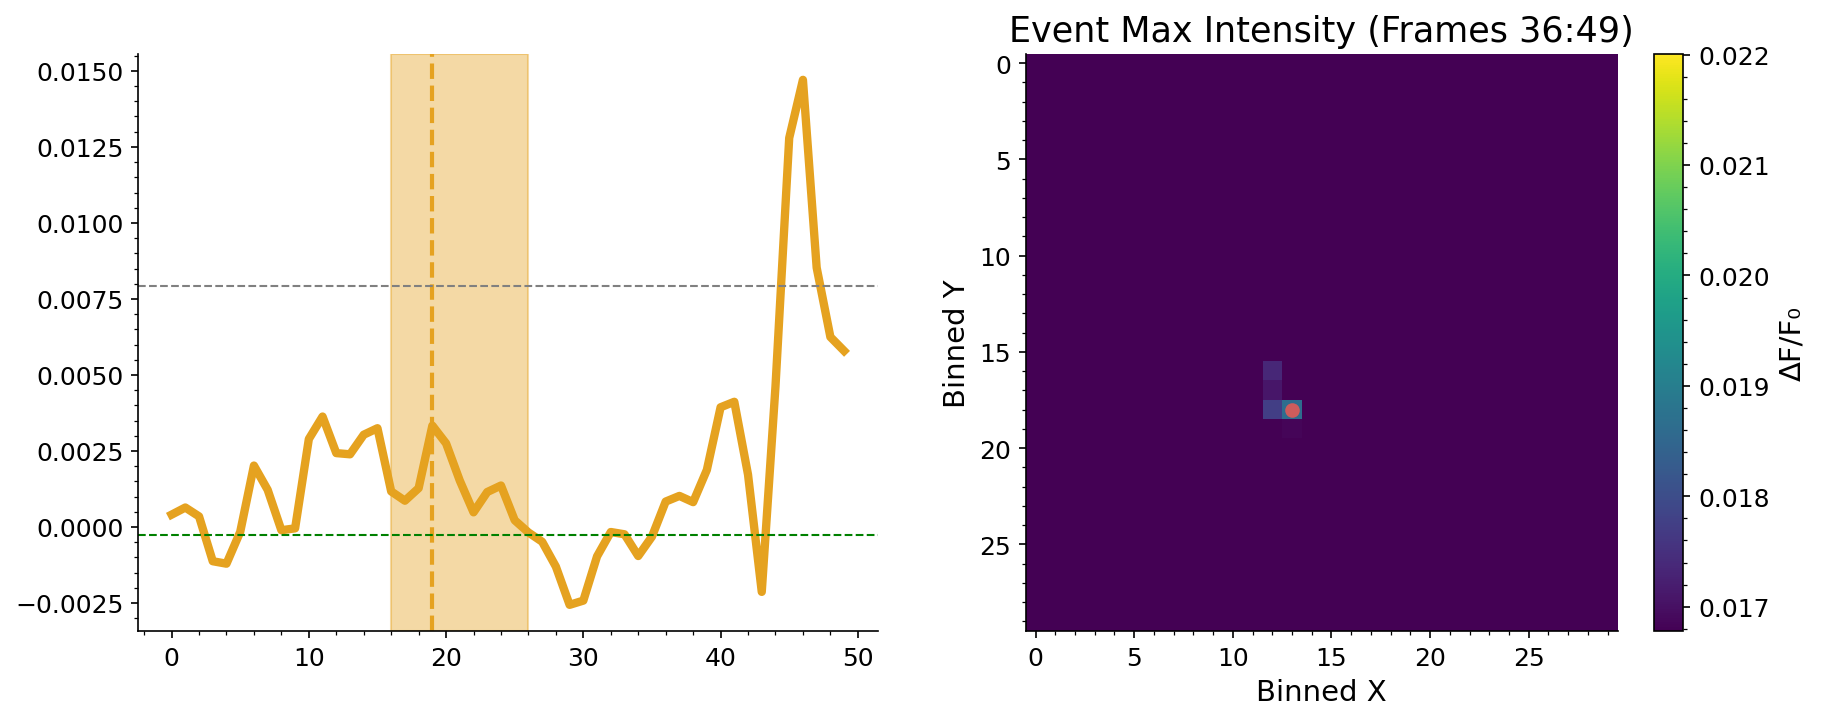

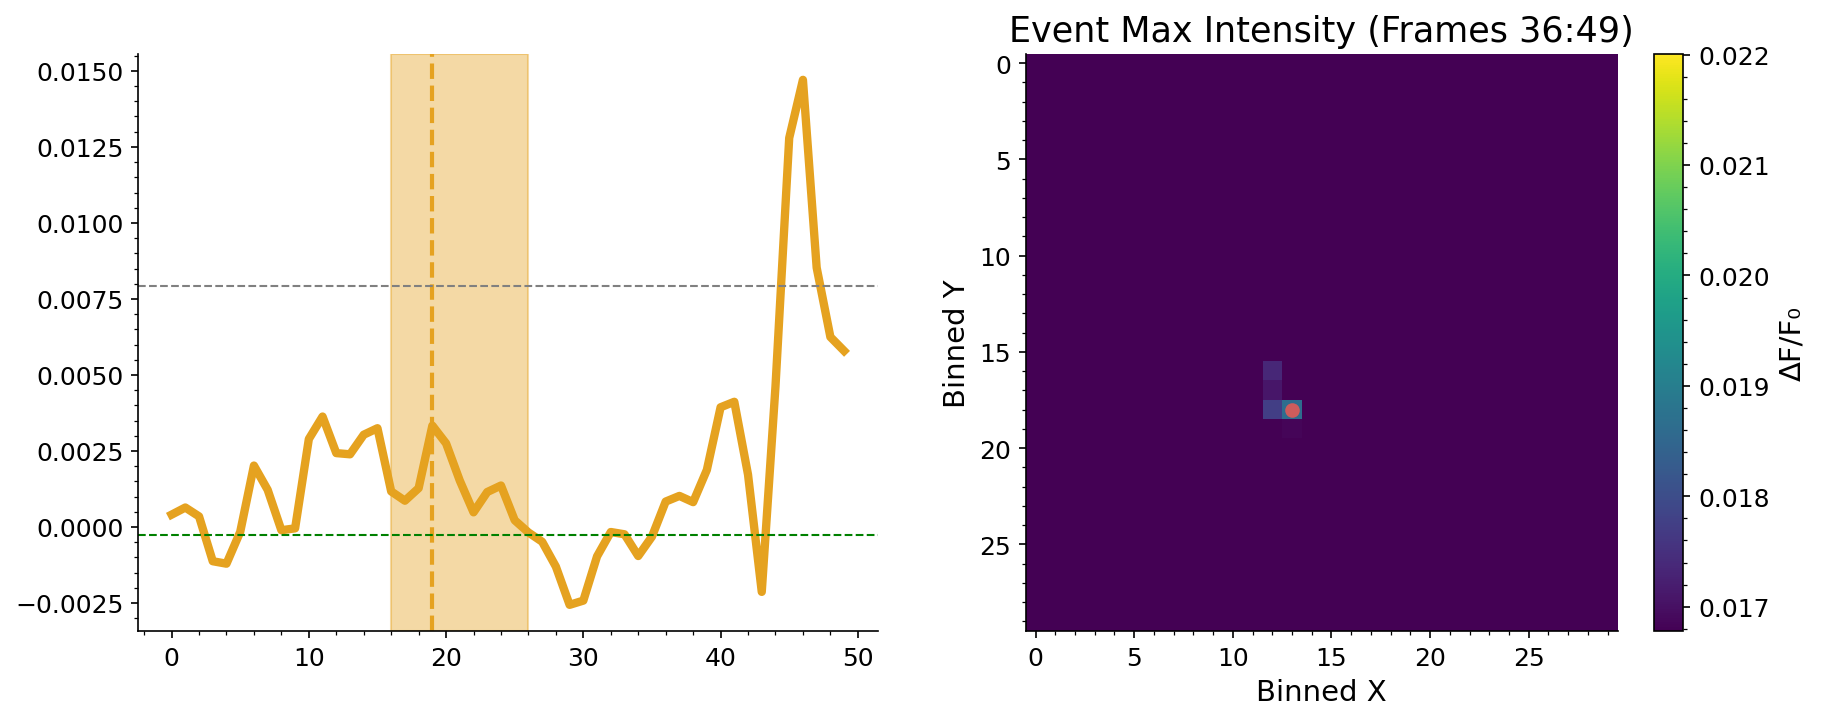

In [120]:
# get_max_bins(all_event_frames, filter_window=5, min_event_length=1, 
#                  prominence=5, threshold=4, min_distance=1, percentile=20, 
#                  filter_polyorder=2)
# #New call: 
get_max_bins(df_groups.to_dict('records'),
             filter_window=5, min_event_length=1,
             prominence=5, threshold=4, min_distance=1,
             percentile=20, filter_polyorder=2)


In [121]:
print(all_event_frames)

[{'start': 18, 'end': 28, 'bins': [(11, 21), (14, 19), (15, 22), (19, 21), (20, 22), (21, 21), (21, 22), (21, 23)], 'peak': 19}, {'start': 36, 'end': 49, 'bins': [(14, 10), (11, 12), (12, 11), (12, 12), (12, 13), (13, 8), (13, 9), (13, 10), (13, 11), (15, 8), (15, 9), (15, 10), (15, 11), (16, 7), (16, 9), (16, 10), (16, 11), (17, 11), (17, 12), (17, 13), (17, 14), (18, 10), (18, 11), (18, 12), (19, 13), (29, 10)], 'peak': 45}]


In [123]:
# simple smoke-test: two nearby bins should merge, distant ones should not
aligned_test = [
    {'start':0,'end':5,'bins':[(10,10)],'peak':2},
    {'start':0,'end':5,'bins':[(10,11)],'peak':2},  # neighbour to (10,10)
    {'start':0,'end':5,'bins':[(20,20)],'peak':2},  # far away
]

groups, member_assignments, coord_to_group = spatial_segment(aligned_test)
print("groups:", groups)
print("coord_to_group:", coord_to_group)
# Expect (10,10) and (10,11) to be in same group_id; (20,20) in a different one


(10, 10)
(10, 10)
(10, 11)
(10, 11)
(20, 20)
(20, 20)
First pass done
Group dictionary built
groups: {1: [(10, 10), (10, 11)], 2: [(20, 20)]}
coord_to_group: {(10, 10): 1, (10, 11): 1, (20, 20): 2}


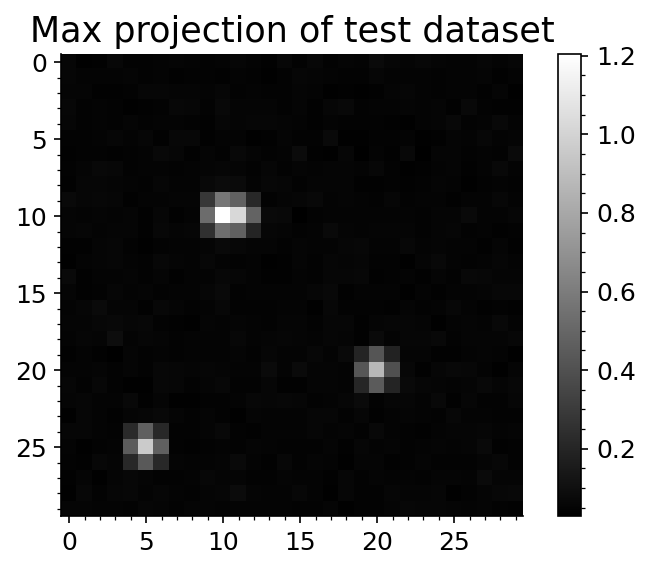

detected events and merged. yay!
(9, 9)
(9, 9)
(9, 10)
(9, 10)
(10, 9)
(10, 9)
(10, 10)
(10, 10)
(11, 9)
(11, 9)
(11, 10)
(11, 10)
(9, 11)
(9, 11)
(9, 12)
(9, 12)
(10, 11)
(10, 11)
(10, 12)
(10, 12)
(11, 11)
(11, 11)
(11, 12)
(11, 12)
(8, 11)
(8, 11)
(19, 19)
(19, 19)
(19, 20)
(19, 20)
(19, 21)
(19, 21)
(20, 19)
(20, 19)
(20, 20)
(20, 20)
(20, 21)
(20, 21)
(21, 19)
(21, 19)
(21, 20)
(21, 20)
(21, 21)
(21, 21)
(9, 9)
(9, 9)
(9, 10)
(9, 10)
(9, 11)
(9, 11)
(10, 9)
(10, 9)
(10, 10)
(10, 10)
(10, 11)
(10, 11)
(11, 9)
(11, 9)
(11, 10)
(11, 10)
(11, 11)
(11, 11)
(24, 4)
(24, 4)
(24, 5)
(24, 5)
(24, 6)
(24, 6)
(25, 4)
(25, 4)
(25, 5)
(25, 5)
(25, 6)
(25, 6)
(26, 4)
(26, 4)
(26, 5)
(26, 5)
(26, 6)
(26, 6)
First pass done
Group dictionary built
   group_id  start  end  peak  n_bins  \
0         1      6   50    42      13   
1         2      6   25    12       9   
2         3     52   71    62       9   

                                                bins  
0  [(8, 11), (9, 9), (9, 10), (9, 

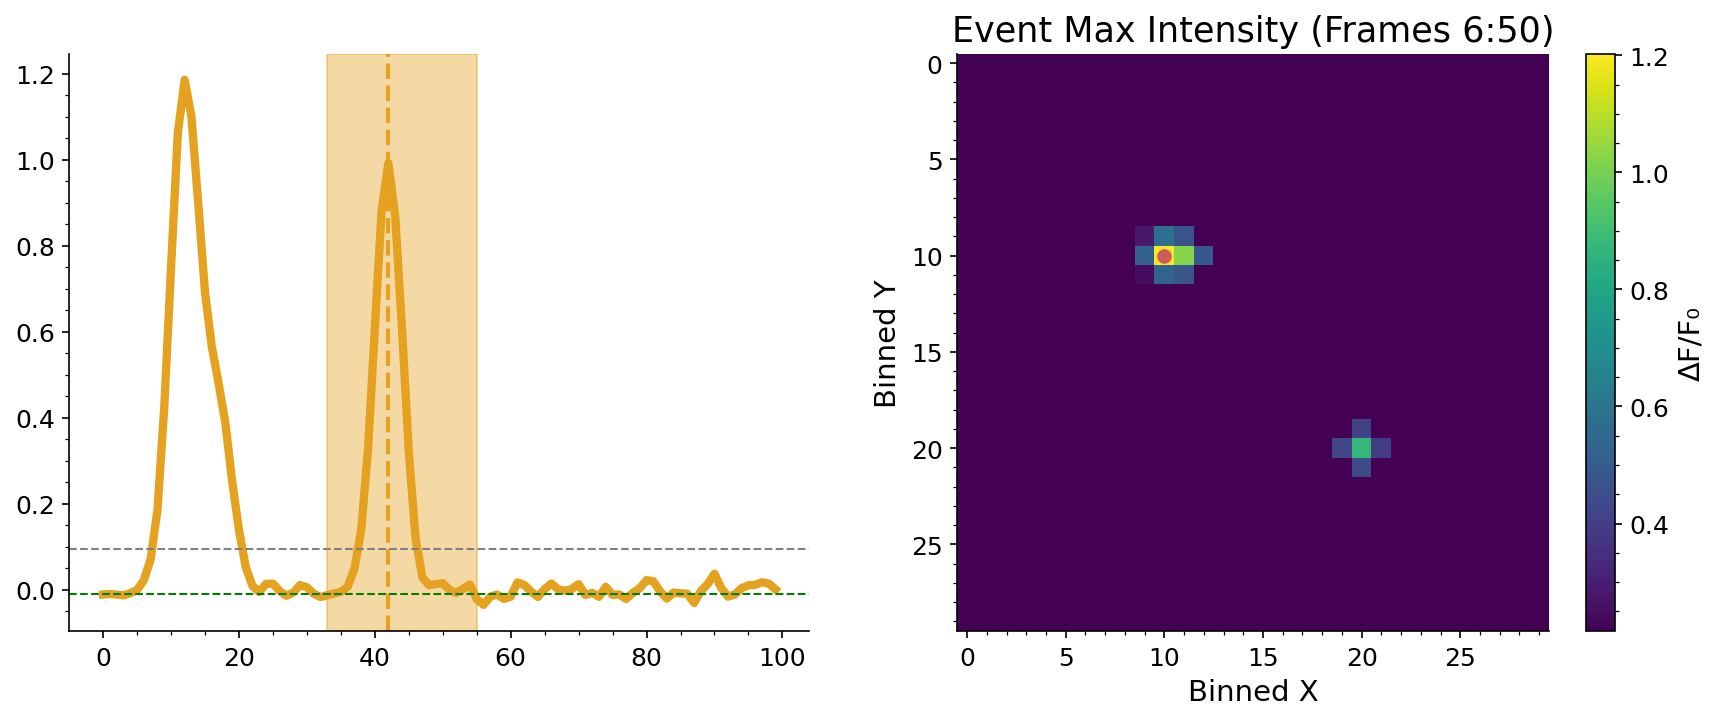

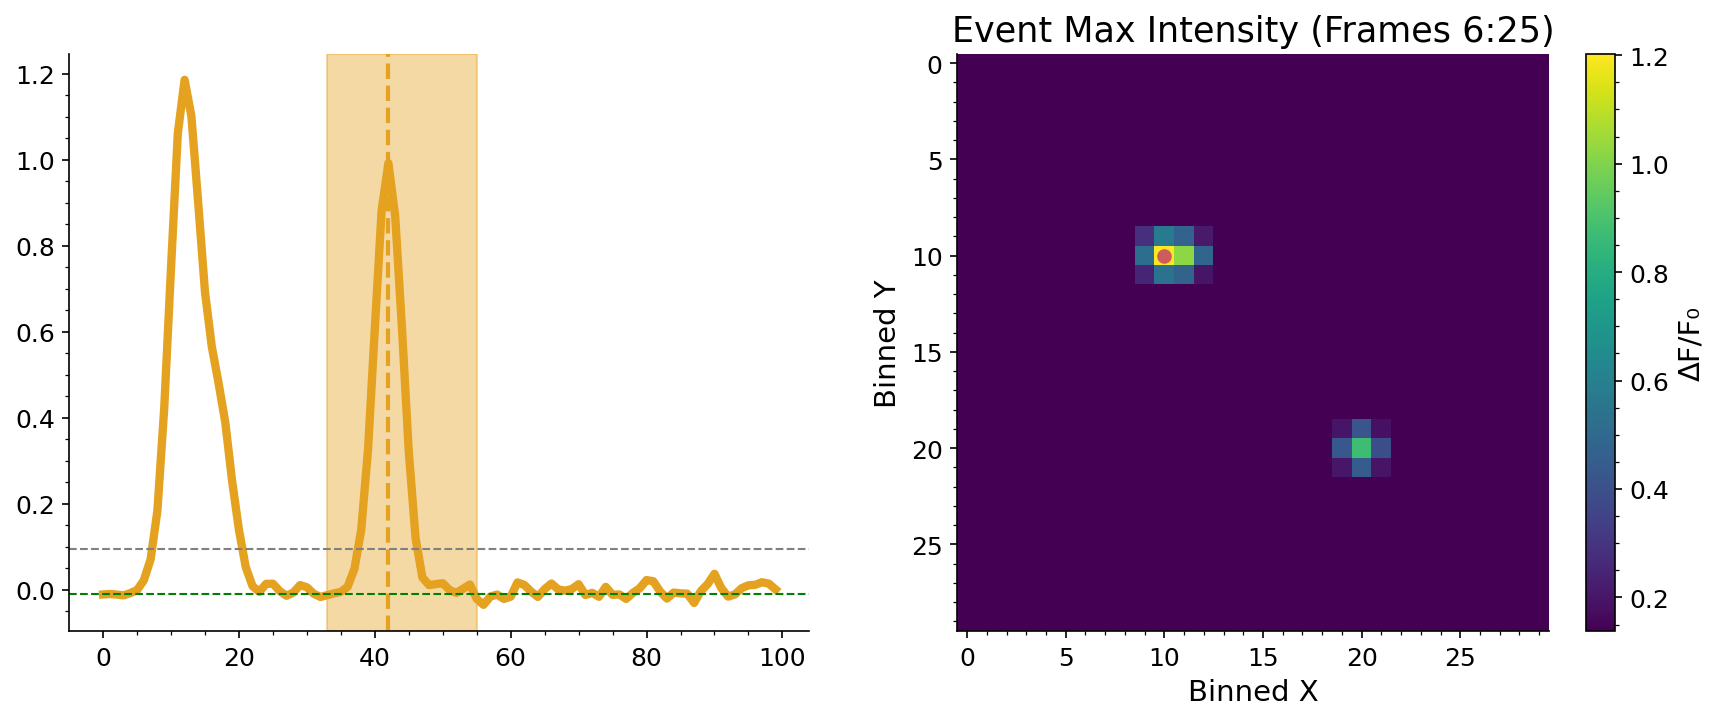

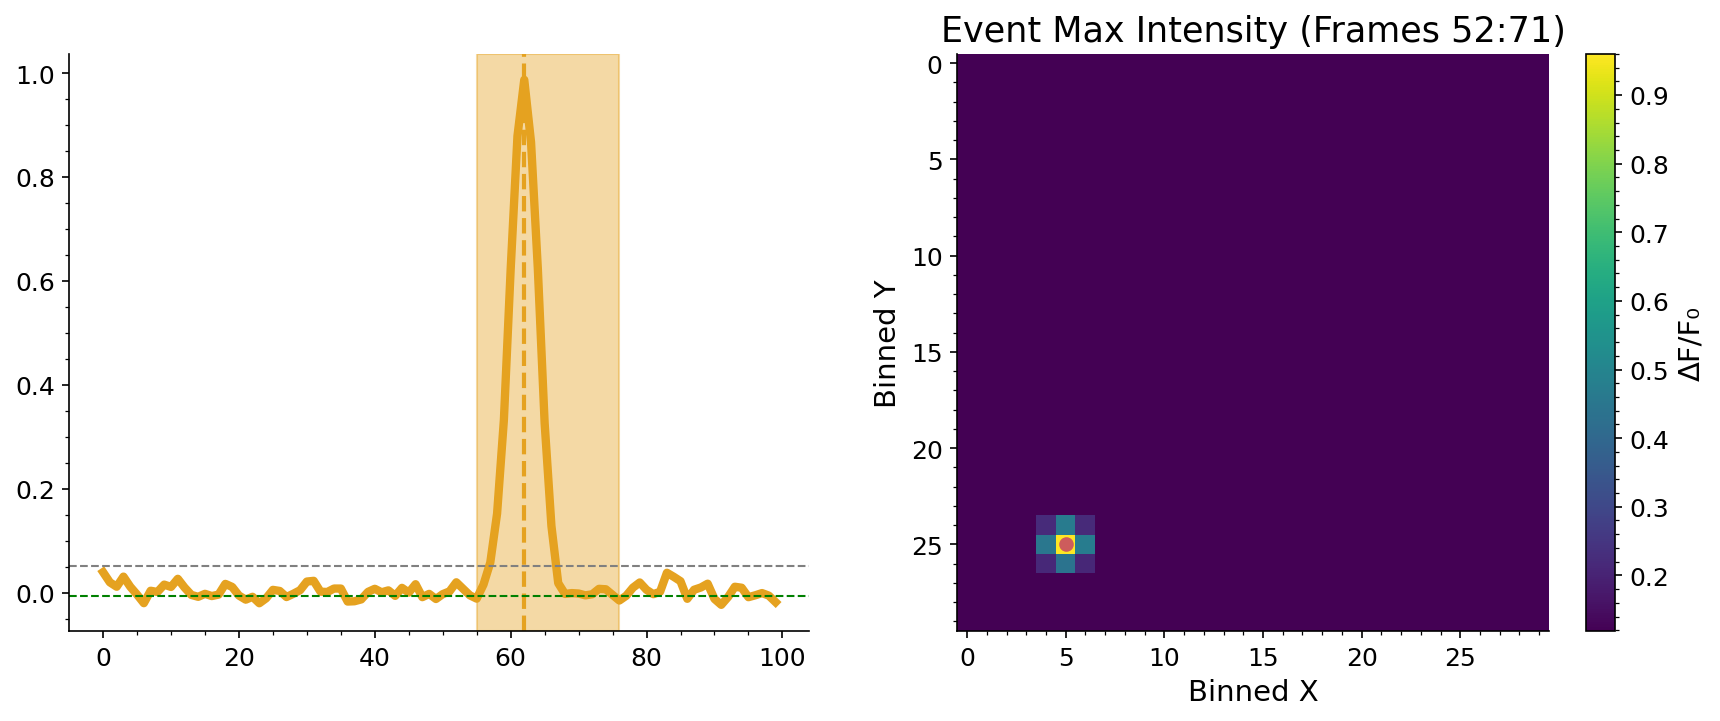

In [127]:
###TESTING WITH A DUMMY DATASET

dff_stack = np.load('/Users/sanjnakartik/Documents/ILESLA/stats/project/ILESLA/test_dff_stack.npy')

import matplotlib.pyplot as plt

plt.imshow(np.max(dff_stack, axis=0))
plt.title("Max projection of test dataset")
plt.colorbar()
plt.show()

all_event_frames = detect_events(dff_stack, bins, filter_window=5, min_event_length=1,                    
                               prominence=6, threshold=5, min_distance=1, percentile=50) 
#here, all_event_frames is being used to store the output of the original code, i.e. events detected, sorted by peak and then merged within 10 frames
print("detected events and merged. yay!")

groups, member_assignments, coord_to_group = spatial_segment(all_event_frames)

group_summaries, df_groups, aligned_event_to_groups = aggregate_aligned_events_to_groups(
    all_event_frames,
    coord_to_group,
    missing_policy="skip",      # or 'new' if you want unmatched coords to become new groups
    peak_aggregation="max"      # or 'mode' / 'median'
)

print(df_groups.head())

get_max_bins(df_groups.to_dict('records'),
             filter_window=5, min_event_length=1,
             prominence=5, threshold=4, min_distance=1,
             percentile=20, filter_polyorder=2)